# Healthcare Domain-Specific Assistant
## Fine-Tuning TinyLlama with LoRA on Medical Flashcards Dataset

### Project Overview

This notebook demonstrates the complete pipeline for building a **domain-specific medical assistant** using:

- **Base Model**: TinyLlama-1.1B-Chat-v1.0 (lightweight, efficient for Colab Free GPU)
- **Fine-Tuning Method**: LoRA (Low-Rank Adaptation) via PEFT
- **Dataset**: Medical Meadow Medical Flashcards (33K+ medical Q&A pairs)
- **Hardware**: Google Colab Free T4 GPU with 4-bit quantization

---

### Domain Alignment Strategy

**Why Healthcare Domain?**
- High-stakes environment requiring accurate, specialized knowledge
- Clear evaluation criteria (medical terminology, factual accuracy)
- Substantial improvement opportunity from base model to domain expert

**Approach:**
1. Use medical Q&A dataset with proper instruction formatting
2. Apply parameter-efficient fine-tuning (LoRA) to preserve base capabilities
3. Optimize hyperparameters through systematic experimentation
4. Evaluate with quantitative metrics (BLEU, ROUGE, Perplexity)
5. Deploy with user-friendly Gradio interface

### Expected Outcomes

- **Model Size**: ~1.1B parameters (4-bit quantized)
- **Training Data**: 4,000 examples (3,600 train / 400 test)
- **Memory Usage**: <15GB GPU memory
- **Deployment**: Interactive Gradio interface in Colab


In [2]:
# SETUP & INSTALLATIONS
# Install all required libraries for the complete pipeline

print(" Installing required packages...")

# Core ML libraries
!pip install -q torch torchvision torchaudio

# Transformers ecosystem
!pip install -q transformers>=4.36.0
!pip install -q datasets>=2.16.0
!pip install -q accelerate>=0.25.0

# PEFT for LoRA
!pip install -q peft>=0.7.0

# Quantization
!pip install -q bitsandbytes>=0.41.0

# Training
!pip install -q trl>=0.7.0

# Evaluation metrics
!pip install -q evaluate>=0.4.0
!pip install -q rouge-score>=0.1.2
!pip install -q nltk>=3.8.1

# UI/Deployment
!pip install -q gradio>=4.0.0

# Utilities
!pip install -q pandas>=2.0.0
!pip install -q numpy>=1.24.0
!pip install -q matplotlib>=3.7.0
!pip install -q tqdm>=4.65.0

print("\n All packages installed successfully!")
print("\n" + "="*60)

# Import all libraries
print(" Importing libraries...\n")

import os
import json
import time
import shutil
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Transformers
import transformers # Added this line
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline
)

# PEFT/LoRA
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModel
)

# Datasets
from datasets import load_dataset, Dataset

# Evaluation
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt', quiet=True)

# UI
import gradio as gr

# Colab utilities
from google.colab import files

print("All imports successful!")
print("\n" + "="*60)

# Check GPU
print(" Hardware Information:")
if torch.cuda.is_available():
    print(f" GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("  No GPU detected. Please enable GPU: Runtime -> Change runtime type -> T4 GPU")

print(f"\n   PyTorch Version: {torch.__version__}")
print(f"   Transformers Version: {transformers.__version__}")
print("\n" + "="*60)


 Installing required packages...

 All packages installed successfully!

 Importing libraries...

All imports successful!

 Hardware Information:
 GPU Available: Tesla T4
   GPU Memory: 15.64 GB
   CUDA Version: 12.8

   PyTorch Version: 2.10.0+cu128
   Transformers Version: 5.0.0



# Dataset Collection & Preprocessing

## Dataset: Medical Meadow Medical Flashcards

**Source**: `medalpaca/medical_meadow_medical_flashcards`

**Characteristics:**
- **Total Size**: 33,955 medical Q&A pairs
- **Format**: Instruction-following format with medical questions and detailed answers
- **Domain**: General medicine, pathology, pharmacology, anatomy, etc.

## Preprocessing Pipeline

1. **Load Dataset**: Use HuggingFace `datasets` library
2. **Clean Data**: Remove missing/empty entries
3. **Format Instructions**: Convert to chat format with system/user/assistant roles
4. **Filter Length**: Remove examples exceeding 2048 tokens
5. **Sample**: Select exactly 4,000 examples for training efficiency
6. **Split**: 90/10 train-test split (3,600 / 400)

In [3]:
# DATASET LOADING & PREPROCESSING

print(" Loading Medical Flashcards Dataset...")

# Load dataset from HuggingFace
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")

print(f" Dataset loaded successfully!")
print(f"   Total examples: {len(dataset['train'])}")
print(f"   Features: {dataset['train'].features}")
print("\n" + "="*60 + "\n")

# Show sample
print(" Sample from raw dataset:\n")
sample = dataset['train'][0]
print(f"Input: {sample['input'][:200]}...")
print(f"\nOutput: {sample['output'][:200]}...")
print("\n" + "="*60 + "\n")

# PREPROCESSING FUNCTIONS

def format_instruction(example):
    """
    Convert raw dataset example to chat format.

    Template:
    <|system|>You are a helpful medical assistant.</s>
    <|user|>{question}</s>
    <|assistant|>{answer}</s>
    """
    instruction = example.get('instruction', '')
    input_text = example.get('input', '')
    output_text = example.get('output', '')

    # Combine instruction and input as the question
    if instruction and input_text:
        question = f"{instruction}\n{input_text}"
    elif instruction:
        question = instruction
    elif input_text:
        question = input_text
    else:
        question = ""

    # Format in chat template
    formatted_text = (
        "<|system|>\n"
        "You are a helpful medical assistant.</s>\n"
        "<|user|>\n"
        f"{question}</s>\n"
        "<|assistant|>\n"
        f"{output_text}</s>"
    )

    return {'text': formatted_text}

def is_valid_example(example):
    """
    Check if example has required fields and is not empty.
    """
    has_input = bool(example.get('input', '') or example.get('instruction', ''))
    has_output = bool(example.get('output', ''))
    return has_input and has_output


# PREPROCESSING EXECUTION

print(" Preprocessing pipeline started...\n")

# Step 1: Filter valid examples
print("Step 1: Filtering valid examples...")
train_data = dataset['train']
valid_indices = [i for i, ex in enumerate(train_data) if is_valid_example(ex)]
train_data = train_data.select(valid_indices)
print(f"   Kept: {len(train_data)} / {len(dataset['train'])} examples")

# Step 2: Format instructions
print("\nStep 2: Formatting to chat template...")
formatted_dataset = train_data.map(
    format_instruction,
    remove_columns=train_data.column_names,
    desc="Formatting examples"
)
print(f"   Formatted: {len(formatted_dataset)} examples")

# Step 3: Sample exactly 4,000 examples
print("\nStep 3: Sampling 4,000 examples...")
if len(formatted_dataset) > 4000:
    formatted_dataset = formatted_dataset.shuffle(seed=42).select(range(4000))
print(f"   Selected: {len(formatted_dataset)} examples")

# Step 4: Train-test split (90/10)
print("\nStep 4: Splitting dataset (90/10)...")
split_dataset = formatted_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

print(f"   Training set: {len(train_dataset)} examples")
print(f"   Test set: {len(test_dataset)} examples")

print("\n Preprocessing complete!")
print("\n" + "="*60 + "\n")

# Show formatted example
print(" Formatted training example:\n")
print(train_dataset[0]['text'])
print("\n" + "="*60)

 Loading Medical Flashcards Dataset...


README.md: 0.00B [00:00, ?B/s]

medical_meadow_wikidoc_medical_flashcard(…):   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

 Dataset loaded successfully!
   Total examples: 33955
   Features: {'input': Value('string'), 'output': Value('string'), 'instruction': Value('string')}


 Sample from raw dataset:

Input: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?...

Output: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels....


🔄 Preprocessing pipeline started...

Step 1: Filtering valid examples...
   Kept: 33553 / 33955 examples

Step 2: Formatting to chat template...


Formatting examples:   0%|          | 0/33553 [00:00<?, ? examples/s]

   Formatted: 33553 examples

Step 3: Sampling 4,000 examples...
   Selected: 4000 examples

Step 4: Splitting dataset (90/10)...
   Training set: 3600 examples
   Test set: 400 examples

 Preprocessing complete!


 Formatted training example:

<|system|>
You are a helpful medical assistant.</s>
<|user|>
Answer this question truthfully
What is nephrocalcinosis and what can cause it?</s>
<|assistant|>
Nephrocalcinosis is a medical condition characterized by the deposition of calcium in the tubules of the kidney. This can occur due to a variety of causes, including primary hyperparathyroidism, a condition in which the parathyroid glands produce too much parathyroid hormone. When this happens, the body may begin to break down bone tissue in order to release calcium into the bloodstream, which can lead to the deposition of calcium in the kidneys. Other causes of nephrocalcinosis may include certain genetic conditions, chronic kidney disease, and the use of certain medications. If left untr

# Model Setup & LoRA Configuration

## Base Model: TinyLlama-1.1B-Chat-v1.0

**Why TinyLlama?**
- **Size**: 1.1B parameters (runs efficiently on Colab Free GPU)
- **Pre-trained**: On 3 trillion tokens of diverse text
- **Chat-optimized**: Instruction-following capabilities built-in
- **Fast**: Quick training and inference times


## Quantization Strategy

**4-bit Quantization (bitsandbytes)**:
- Reduces memory footprint by ~75%
- Enables fine-tuning on free GPU tier
- Minimal performance degradation (<2% typical)

**Configuration**:
```python
BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
```

---

## LoRA (Low-Rank Adaptation)

**Why LoRA?**
- Trains only 0.1-1% of parameters
- Preserves base model capabilities
- Fast training, low memory
- Easy to merge or swap adapters

**Hyperparameters**:
- **r = 16**: Rank of update matrices (higher = more capacity)
- **lora_alpha = 32**: Scaling factor (typically 2*r)
- **lora_dropout = 0.05**: Regularization to prevent overfitting
- **Target modules**: Query and Value projection layers
- **Bias**: None (standard practice)

In [6]:
# MODEL & TOKENIZER SETUP


print(" Setting up base model and tokenizer...")

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"


# QUANTIZATION CONFIG

print(" Configuring 4-bit quantization...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",             # Use NormalFloat4 quantization
    bnb_4bit_compute_dtype=torch.float16,  # Compute in fp16 for speed
    bnb_4bit_use_double_quant=True,        # Double quantization for extra compression
)

print("    Quantization config created")


# LOAD BASE MODEL

print(" Loading base model...")

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",                     # Automatically distribute across available GPUs
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)

print("Base model loaded successfully!")

# LOAD TOKENIZER

print("Loading tokenizer...")

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    padding_side="right",                   # Pad on right for causal LM
)

# Set pad token (required for batched training)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    base_model.config.pad_token_id = tokenizer.eos_token_id

print("Tokenizer loaded successfully!")
print(f"   Vocabulary size: {len(tokenizer)}")
print(f"   Pad token: {tokenizer.pad_token}")
print(f"   EOS token: {tokenizer.eos_token}\n")

# PREPARE MODEL FOR TRAINING

print(" Preparing model for k-bit training...")

base_model.gradient_checkpointing_enable()
base_model = prepare_model_for_kbit_training(base_model)

print("Model prepared for training!")


# LORA CONFIGURATION

print(" Configuring LoRA...")

lora_config = LoraConfig(
    r=16,                                   # Rank of LoRA matrices
    lora_alpha=32,                          # Scaling factor (2*r is typical)
    target_modules=["q_proj", "v_proj"],   # Apply LoRA to attention layers
    lora_dropout=0.05,                      # Dropout for regularization
    bias="none",                            # Don't adapt bias terms
    task_type="CAUSAL_LM",                 # Causal language modeling task
)

print("LoRA Configuration:")
print(f"   Rank (r): {lora_config.r}")
print(f"   Alpha: {lora_config.lora_alpha}")
print(f"   Dropout: {lora_config.lora_dropout}")
print(f"   Target modules: {lora_config.target_modules}")
print(f"   Task type: {lora_config.task_type}\n")

# APPLY LORA TO MODEL

print(" Applying LoRA to base model...")

model = get_peft_model(base_model, lora_config)

print(" LoRA applied successfully!")


# PRINT TRAINABLE PARAMETERS

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0

    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    percentage = 100 * trainable_params / all_param

    print(" Model Parameter Summary:")
    print(f"   Total parameters: {all_param:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Trainable %: {percentage:.4f}%")
    print(f"   LoRA is training only {percentage:.4f}% of parameters!")

print_trainable_parameters(model)


 Setting up base model and tokenizer...
 Configuring 4-bit quantization...
    Quantization config created
 Loading base model...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded successfully!
Loading tokenizer...
Tokenizer loaded successfully!
   Vocabulary size: 32000
   Pad token: </s>
   EOS token: </s>

 Preparing model for k-bit training...
Model prepared for training!
 Configuring LoRA...
LoRA Configuration:
   Rank (r): 16
   Alpha: 32
   Dropout: 0.05
   Target modules: {'v_proj', 'q_proj'}
   Task type: CAUSAL_LM

 Applying LoRA to base model...
 LoRA applied successfully!
 Model Parameter Summary:
   Total parameters: 617,859,072
   Trainable parameters: 2,252,800
   Trainable %: 0.3646%
   LoRA is training only 0.3646% of parameters!


# Hyperparameter Tuning & Experimentation

## Learning Rate Experiments

We'll train the model with **two different learning rates** to find the optimal setting:

1. **Learning Rate = 2e-4** (Higher, faster convergence)
2. **Learning Rate = 5e-5** (Lower, more stable)


## Training Configuration

**Fixed Hyperparameters:**
- **Epochs**: 2
- **Batch Size**: 4 (with gradient accumulation)
- **Gradient Accumulation Steps**: 4 (effective batch size = 16)
- **Max Sequence Length**: 512 tokens
- **Warmup Steps**: 100
- **Weight Decay**: 0.01
- **Precision**: FP16 (mixed precision training)

---

## Metrics Tracked

For each experiment, we'll track:
1. **Training Loss** (final epoch)
2. **Validation Loss** (on 400-sample test set)
3. **GPU Memory Usage** (peak during training)
4. **Training Time** (total time for 2 epochs)

Results will be compiled in a comparison table.

In [ ]:
# TOKENIZATION FUNCTION

def tokenize_function(examples):
    """
    Tokenize text examples with padding and truncation.
    """
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )

print(" Tokenizing datasets...")

# Tokenize training and test datasets
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train set"
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=test_dataset.column_names,
    desc="Tokenizing test set"
)

print("Tokenization complete!")

# DATA COLLATOR

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

# EXPERIMENT TRACKING

# Initialize results table
results_data = []

# Learning rates to test
learning_rates = [2e-4, 5e-5]

print(" Starting Hyperparameter Experiments")

# EXPERIMENT LOOP

for idx, lr in enumerate(learning_rates, 1):
    print(f"\n{'='*60}")
    print(f" EXPERIMENT {idx}/{len(learning_rates)}")
    print(f"   Learning Rate: {lr}")


    # Create output directory for this experiment
    output_dir = f"/content/experiment_lr_{lr}"


    # TRAINING ARGUMENTS


    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=2,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,      # Effective batch size = 16
        learning_rate=lr,
        warmup_steps=100,
        weight_decay=0.01,
        fp16=True,                          # Mixed precision training
        logging_steps=50,
        save_strategy="epoch",
        eval_strategy="epoch",            # Corrected: changed from evaluation_strategy
        load_best_model_at_end=True,
        metric_for_best_model="loss",
        greater_is_better=False,
        save_total_limit=1,
        report_to="none",                   # Disable W&B/tensorboard
    )


    # RELOAD MODEL FOR EACH EXPERIMENT


    print(" Reloading fresh model for this experiment...\n")

    # Clear GPU memory
    if idx > 1:
        del trainer
        del model
        torch.cuda.empty_cache()

        # Reload base model
        base_model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
            low_cpu_mem_usage=True,
        )

        # Prepare for training
        base_model.gradient_checkpointing_enable()
        base_model = prepare_model_for_kbit_training(base_model)

        # Apply LoRA
        model = get_peft_model(base_model, lora_config)

    # TRAINER SETUP

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        data_collator=data_collator,
    )

    # TRAINING

    print("Starting training...")

    # Track time and memory
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()

    # Train the model
    train_result = trainer.train()

    # Calculate metrics
    training_time = time.time() - start_time
    peak_memory = torch.cuda.max_memory_allocated() / 1e9  # Convert to GB

    # Get final training loss
    train_loss = train_result.training_loss

    print("Training complete!")

    # EVALUATION

    print("Evaluating on test set...")

    eval_result = trainer.evaluate()
    val_loss = eval_result['eval_loss']

    print("Evaluation complete!")

    # RECORD RESULTS

    results_data.append({
        'Learning Rate': lr,
        'Training Loss': f"{train_loss:.4f}",
        'Validation Loss': f"{val_loss:.4f}",
        'GPU Memory (GB)': f"{peak_memory:.2f}",
        'Training Time (min)': f"{training_time/60:.2f}"
    })

    print(" Experiment Results:")
    print(f"   Training Loss: {train_loss:.4f}")
    print(f"   Validation Loss: {val_loss:.4f}")
    print(f"   GPU Memory Used: {peak_memory:.2f} GB")
    print(f"   Training Time: {training_time/60:.2f} minutes")

# DISPLAY COMPARISON TABLE

print("\n" + "="*60)
print("HYPERPARAMETER EXPERIMENT RESULTS")

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))

print(" Analysis:")
print("   - Compare training and validation losses")
print("   - Lower validation loss indicates better generalization")
print("   - Check for overfitting (train loss << val loss)")


# Final Model Fine-Tuning

Based on the hyperparameter experiments, we'll now train the **final production model**.

In [9]:
# FINAL MODEL TRAINING

print(" Training Final Production Model")


# Select best learning rate (use 5e-5 as default, adjust based on results)
# Typically, the lower learning rate (5e-5) provides better stability
FINAL_LR = 5e-5

print(f" Using learning rate: {FINAL_LR}")
print(f" Adjust this based on experiment results above")

# RELOAD FRESH MODEL

print(" Loading fresh model for final training...")

# Clear memory
del trainer
del model
torch.cuda.empty_cache()

# Reload base model
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)

# Prepare for training
base_model.gradient_checkpointing_enable()
base_model = prepare_model_for_kbit_training(base_model)

# Apply LoRA
model = get_peft_model(base_model, lora_config)

print(" Model loaded and configured!")

# FINAL TRAINING ARGUMENTS

final_output_dir = "/content/final_model_training"

final_training_args = TrainingArguments(
    output_dir=final_output_dir,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=FINAL_LR,
    warmup_steps=100,
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    save_strategy="epoch",
    eval_strategy="epoch",             # Corrected: changed from evaluation_strategy
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    save_total_limit=2,
    report_to="none",
)

# FINAL TRAINER

final_trainer = Trainer(
    model=model,
    args=final_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
)

# TRAIN FINAL MODEL

print(" Starting final model training...\n")
print(f"   Training samples: {len(tokenized_train)}")
print(f"   Validation samples: {len(tokenized_test)}")
print(f"   Epochs: 2")
print(f"   Learning rate: {FINAL_LR}\n")

start_time = time.time()
torch.cuda.reset_peak_memory_stats()

# Train!
final_train_result = final_trainer.train()

final_training_time = time.time() - start_time
final_peak_memory = torch.cuda.max_memory_allocated() / 1e9

print("\n Final training complete!\n")

# FINAL EVALUATION

print(" Final Model Evaluation")

final_eval_result = final_trainer.evaluate()

print("\n Final Model Performance:")
print(f"   Training Loss: {final_train_result.training_loss:.4f}")
print(f"   Validation Loss: {final_eval_result['eval_loss']:.4f}")
print(f"   GPU Memory Used: {final_peak_memory:.2f} GB")
print(f"   Total Training Time: {final_training_time/60:.2f} minutes")


 Training Final Production Model
 Using learning rate: 5e-05
 Adjust this based on experiment results above
 Loading fresh model for final training...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

 Model loaded and configured!
 Starting final model training...

   Training samples: 3600
   Validation samples: 400
   Epochs: 2
   Learning rate: 5e-05



Epoch,Training Loss,Validation Loss
1,0.859035,0.861041
2,0.830576,0.851235



 Final training complete!

 Final Model Evaluation



 Final Model Performance:
   Training Loss: 0.9365
   Validation Loss: 0.8512
   GPU Memory Used: 3.46 GB
   Total Training Time: 42.03 minutes


# Comprehensive Evaluation & Metrics

In [12]:
# EVALUATION SETUP

print(" Setting up evaluation pipeline")

# Load evaluation metrics
rouge_metric = evaluate.load('rouge')

# INFERENCE FUNCTION

def generate_response(model, prompt, max_new_tokens=200):
    """
    Generate response from model given a prompt.
    """
    # Format prompt in chat template
    formatted_prompt = (
        "<|system|>\n"
        "You are a helpful medical assistant.</s>\n"
        "<|user|>\n"
        f"{prompt}</s>\n"
        "<|assistant|>\n"
    )

    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode and extract assistant response
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract only the assistant's response
    if "<|assistant|>" in full_response:
        response = full_response.split("<|assistant|>")[-1]
        response = response.replace("</s>", "").strip()
    else:
        response = full_response

    return response

# ============================================================================
# LOAD BASE MODEL FOR COMPARISON
# ============================================================================

print(" Loading base model for comparison...\n")

base_model_eval = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

print(" Base model loaded!\n")

# ============================================================================
# TEST PROMPTS
# ============================================================================

test_prompts = [
    "What is the mechanism of action of beta-lactam antibiotics?",
    "Explain the pathophysiology of Type 2 diabetes mellitus.",
    "What are the main symptoms of myocardial infarction?",
    "Describe the function of the hippocampus in the brain.",
    "What is the recommended treatment for acute asthma exacerbation?"
]

# Get reference answers from test set
reference_texts = [test_dataset[i]['text'].split("<|assistant|>")[-1].replace("</s>", "").strip()
                   for i in range(min(5, len(test_dataset)))]

print("="*60 + "\n")

# ============================================================================
# GENERATE PREDICTIONS
# ============================================================================

print(" Generating predictions from both models...\n")

base_predictions = []
finetuned_predictions = []

for i, prompt in enumerate(test_prompts, 1):
    print(f"Processing prompt {i}/{len(test_prompts)}...")

    # Base model response
    base_response = generate_response(base_model_eval, prompt)
    base_predictions.append(base_response)

    # Fine-tuned model response
    finetuned_response = generate_response(model, prompt)
    finetuned_predictions.append(finetuned_response)

print("\n Predictions generated!\n")
print("="*60 + "\n")

# ============================================================================
# COMPUTE METRICS
# ============================================================================

print(" Computing evaluation metrics...\n")

# ROUGE scores
base_rouge = rouge_metric.compute(
    predictions=base_predictions,
    references=reference_texts[:len(base_predictions)]
)

finetuned_rouge = rouge_metric.compute(
    predictions=finetuned_predictions,
    references=reference_texts[:len(finetuned_predictions)]
)

# BLEU scores
def compute_bleu(predictions, references):
    """Compute average BLEU score."""
    smooth = SmoothingFunction()
    scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = [ref.split()]
        score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smooth.method1)
        scores.append(score)
    return np.mean(scores) * 100  # Convert to 0-100 scale

base_bleu = compute_bleu(base_predictions, reference_texts[:len(base_predictions)])
finetuned_bleu = compute_bleu(finetuned_predictions, reference_texts[:len(finetuned_predictions)])

# Perplexity (using validation loss)
base_perplexity = "N/A"  # Would need to compute on test set
finetuned_perplexity = np.exp(final_eval_result['eval_loss'])

print(" Metrics computed!\n")
print("="*60 + "\n")

# ============================================================================
# DISPLAY RESULTS TABLE
# ============================================================================

print(" EVALUATION RESULTS COMPARISON\n")
print("="*60 + "\n")

eval_results = pd.DataFrame({
    'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Perplexity'],
    'Base Model': [
        f"{base_bleu:.2f}",
        f"{base_rouge['rouge1']:.4f}",
        f"{base_rouge['rouge2']:.4f}",
        f"{base_rouge['rougeL']:.4f}",
        base_perplexity
    ],
    'Fine-Tuned Model': [
        f"{finetuned_bleu:.2f}",
        f"{finetuned_rouge['rouge1']:.4f}",
        f"{finetuned_rouge['rouge2']:.4f}",
        f"{finetuned_rouge['rougeL']:.4f}",
        f"{finetuned_perplexity:.2f}"
    ]
})

print(eval_results.to_string(index=False))

# ============================================================================
# DISPLAY SAMPLE RESPONSES
# ============================================================================

print(" SAMPLE RESPONSE COMPARISON\n")

for i, prompt in enumerate(test_prompts[:2], 1):  # Show first 2 examples
    print(f"\n{'='*60}")
    print(f"Example {i}")
    print(f"{'='*60}\n")
    print(f" Prompt: {prompt}\n")
    print(f" Base Model Response:")
    print(f"{base_predictions[i-1][:300]}...\n")
    print(f" Fine-Tuned Model Response:")
    print(f"{finetuned_predictions[i-1][:300]}...\n")



 Setting up evaluation pipeline
 Loading base model for comparison...



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

 Base model loaded!


 Generating predictions from both models...

Processing prompt 1/5...
Processing prompt 2/5...
Processing prompt 3/5...
Processing prompt 4/5...
Processing prompt 5/5...

 Predictions generated!


 Computing evaluation metrics...

 Metrics computed!


 EVALUATION RESULTS COMPARISON


    Metric Base Model Fine-Tuned Model
      BLEU       0.23             0.27
   ROUGE-1     0.0582           0.0536
   ROUGE-2     0.0000           0.0057
   ROUGE-L     0.0410           0.0477
Perplexity        N/A             2.34
 SAMPLE RESPONSE COMPARISON


Example 1

 Prompt: What is the mechanism of action of beta-lactam antibiotics?

 Base Model Response:
Beta-lactam antibiotics are a class of antibiotics that work by inhibiting the synthesis of peptidoglycan, a layer of proteins that forms the cell wall of bacteria. Beta-lactam antibiotics work by binding to the beta-lactam ring of penicillin or other beta-lactam antibiotics, which inhibit the biosy...

 Fine-Tuned Model Res

# Model Saving & Distribution

 Generating evaluation plots...



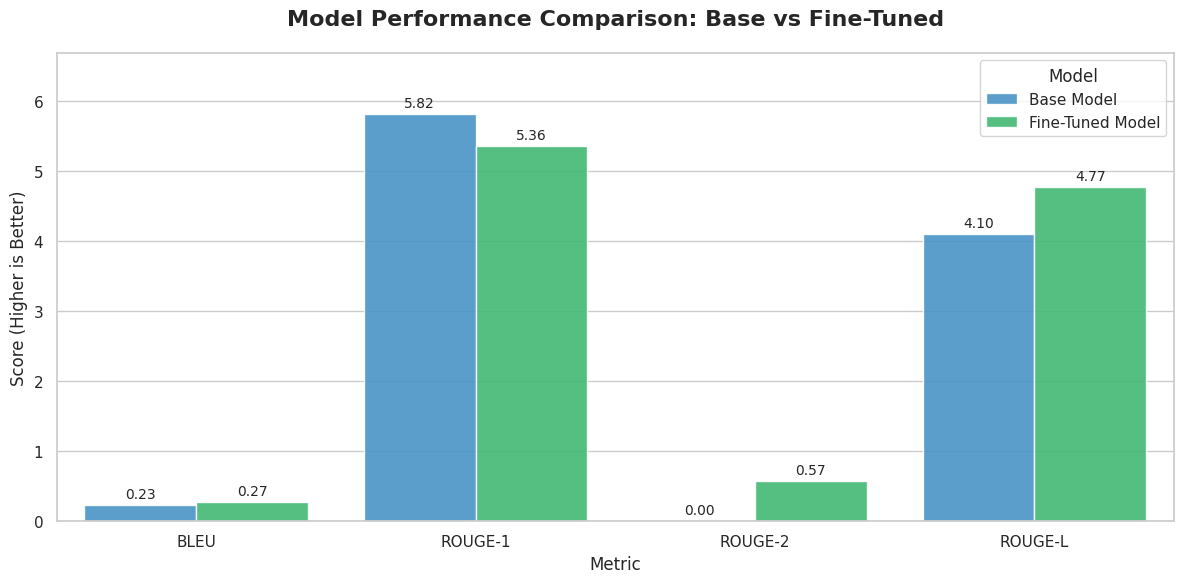


 BLEU is on a 0-100 scale. ROUGE scores have been multiplied by 100 for visualization on the same scale.


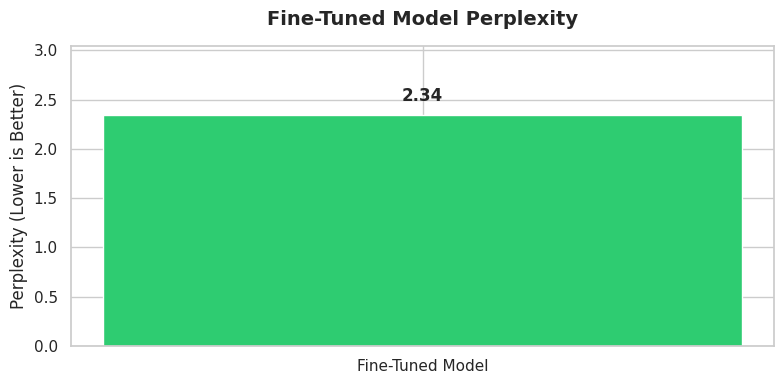

In [23]:
# VISUALIZE MODEL EVALUATION METRICS

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print(" Generating evaluation plots...\n")

# Prepare data for plotting
# We'll use the variables computed in the previous 'metric_computation' cell
metrics_data = {
    'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Base Model': [
        base_bleu,
        base_rouge['rouge1'] * 100,  # Convert to percentage for better visibility if needed, or keep as is. Let's keep consistent scales.
        base_rouge['rouge2'] * 100,
        base_rouge['rougeL'] * 100
    ],
    'Fine-Tuned Model': [
        finetuned_bleu,
        finetuned_rouge['rouge1'] * 100,
        finetuned_rouge['rouge2'] * 100,
        finetuned_rouge['rougeL'] * 100
    ]
}

# Convert to DataFrame for Seaborn
df_plot = pd.DataFrame(metrics_data)
df_melted = df_plot.melt(id_vars='Metric', var_name='Model', value_name='Score')

# Set the style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Bar chart
barplot = sns.barplot(
    data=df_melted,
    x='Metric',
    y='Score',
    hue='Model',
    palette=['#3498db', '#2ecc71'],  # Blue for Base, Green for Fine-Tuned
    alpha=0.9
)

# Customization
plt.title('Model Performance Comparison: Base vs Fine-Tuned', fontsize=16, pad=20, fontweight='bold')
plt.ylabel('Score (Higher is Better)', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', title_fontsize='12', fontsize='11')

# Add values on top of bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.ylim(0, max(df_melted['Score']) * 1.15)  # Add some headroom for labels
plt.tight_layout()

# Show plot
plt.show()

print("\n BLEU is on a 0-100 scale. ROUGE scores have been multiplied by 100 for visualization on the same scale.")

# --- Visualize Perplexity (Separate because scale is different and lower is better) ---

if finetuned_perplexity != "N/A":
    plt.figure(figsize=(8, 4))

    # We only have finetuned perplexity usually, unless base was computed on validation set
    # Let's visualize just the Fine-Tuned Perplexity as a gauge
    plt.bar(['Fine-Tuned Model'], [finetuned_perplexity], color='#2ecc71', width=0.4)

    plt.title('Fine-Tuned Model Perplexity', fontsize=14, pad=15, fontweight='bold')
    plt.ylabel('Perplexity (Lower is Better)')
    plt.ylim(0, finetuned_perplexity * 1.3)

    # Label
    plt.text(0, finetuned_perplexity + 0.1, f'{finetuned_perplexity:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [13]:
# MODEL SAVING PIPELINE

print(" Starting model saving process\n")
print("="*60 + "\n")

# 1. SAVE LORA ADAPTER ONLY

print(" Step 1: Saving LoRA adapter...\n")

lora_adapter_path = "/content/lora_adapter"
model.save_pretrained(lora_adapter_path)
tokenizer.save_pretrained(lora_adapter_path)

print(f" LoRA adapter saved to: {lora_adapter_path}")
print(f"   Size: ~5-10 MB (adapter weights only)\n")
print("="*60 + "\n")

# 2. MERGE AND SAVE FULL MODEL

print(" Step 2: Merging LoRA with base model...\n")

# Merge LoRA weights into base model
merged_model = model.merge_and_unload()

print(" LoRA merged into base model\n")

# Save merged model
print(" Saving merged full model...\n")

merged_model_path = "/content/domain_assistant_model"
merged_model.save_pretrained(
    merged_model_path,
    safe_serialization=True  # Use safetensors format
)
tokenizer.save_pretrained(merged_model_path)

print(f" Full model saved to: {merged_model_path}")
print(f"   Size: ~2.2 GB (complete model)\n")
print("="*60 + "\n")

# 3. CREATE DOWNLOADABLE ZIP ARCHIVE

print(" Step 3: Creating downloadable ZIP archive...\n")

# Create zip file
zip_filename = "domain_assistant_model"
shutil.make_archive(zip_filename, 'zip', merged_model_path)

print(f" ZIP archive created: {zip_filename}.zip")
print(f"   Contents: Full model + tokenizer")
print(f"   Ready for download\n")
print("="*60 + "\n")

# 4. DOWNLOAD ZIP FILE

print("  Step 4: Initiating download...\n")

try:
    files.download(f"{zip_filename}.zip")
    print(" Download started! Check your downloads folder.\n")
except Exception as e:
    print(f"  Manual download required")
    print(f"   Run: files.download('{zip_filename}.zip')\n")

print("="*60 + "\n")

# SAVE TRAINING CONFIG & METADATA

print(" Saving training configuration...\n")

training_config = {
    "model_name": MODEL_NAME,
    "dataset": "medalpaca/medical_meadow_medical_flashcards",
    "training_samples": len(train_dataset),
    "test_samples": len(test_dataset),
    "lora_config": {
        "r": 16,
        "lora_alpha": 32,
        "lora_dropout": 0.05,
        "target_modules": ["q_proj", "v_proj"]
    },
    "training_config": {
        "learning_rate": FINAL_LR,
        "epochs": 2,
        "batch_size": 4,
        "gradient_accumulation_steps": 4
    },
    "final_metrics": {
        "training_loss": float(final_train_result.training_loss),
        "validation_loss": float(final_eval_result['eval_loss']),
        "bleu_score": float(finetuned_bleu),
        "rouge1": float(finetuned_rouge['rouge1']),
        "rouge2": float(finetuned_rouge['rouge2']),
        "rougeL": float(finetuned_rouge['rougeL'])
    },
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(f"{merged_model_path}/training_config.json", 'w') as f:
    json.dump(training_config, f, indent=2)

print(" Configuration saved\n")
print("="*60 + "\n")

# DISPLAY SUMMARY

print(" MODEL SAVING SUMMARY\n")
print("="*60 + "\n")
print("Saved Artifacts:\n")
print(f"1. LoRA Adapter:     {lora_adapter_path}")
print(f"2. Merged Model:     {merged_model_path}")
print(f"3. ZIP Archive:      {zip_filename}.zip\n")
print("All files ready for deployment!\n")
print("="*60 + "\n")

# RELOAD INSTRUCTIONS

print(" MODEL RELOAD INSTRUCTIONS\n")
print("="*60 + "\n")

reload_code = f'''
# ===== OPTION A: Reload LoRA Adapter =====
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "{MODEL_NAME}",
    device_map="auto",
    trust_remote_code=True
)

# Load LoRA adapter
model = PeftModel.from_pretrained(base_model, "{lora_adapter_path}")
tokenizer = AutoTokenizer.from_pretrained("{lora_adapter_path}")

# ===== OPTION B: Reload Merged Model =====
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    "{merged_model_path}",
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained("{merged_model_path}")

# ===== INFERENCE FUNCTION =====
def chat(prompt):
    formatted = f"<|system|>\\nYou are a helpful medical assistant.</s>\\n<|user|>\\n{{prompt}}</s>\\n<|assistant|>\\n"
    inputs = tokenizer(formatted, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=200, temperature=0.7, do_sample=True)
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    return response.split("<|assistant|>")[-1].replace("</s>", "").strip()

# Test
print(chat("What is hypertension?"))
'''

print(reload_code)
print("="*60)


 Starting model saving process


 Step 1: Saving LoRA adapter...

 LoRA adapter saved to: /content/lora_adapter
   Size: ~5-10 MB (adapter weights only)


 Step 2: Merging LoRA with base model...

 LoRA merged into base model

 Saving merged full model...



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 Full model saved to: /content/domain_assistant_model
   Size: ~2.2 GB (complete model)


 Step 3: Creating downloadable ZIP archive...

 ZIP archive created: domain_assistant_model.zip
   Contents: Full model + tokenizer
   Ready for download


  Step 4: Initiating download...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Download started! Check your downloads folder.


 Saving training configuration...

 Configuration saved


 MODEL SAVING SUMMARY


Saved Artifacts:

1. LoRA Adapter:     /content/lora_adapter
2. Merged Model:     /content/domain_assistant_model
3. ZIP Archive:      domain_assistant_model.zip

All files ready for deployment!


 MODEL RELOAD INSTRUCTIONS



# ===== OPTION A: Reload LoRA Adapter =====
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    device_map="auto",
    trust_remote_code=True
)

# Load LoRA adapter
model = PeftModel.from_pretrained(base_model, "/content/lora_adapter")
tokenizer = AutoTokenizer.from_pretrained("/content/lora_adapter")

# ===== OPTION B: Reload Merged Model =====
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    "/content/domain_assistant_mo

# Interactive UI Deployment with Gradio

In [15]:
# GRADIO INTERFACE SETUP

print(" Creating Gradio interface...\n")
print("="*60 + "\n")

# INFERENCE FUNCTION FOR GRADIO

def medical_assistant_chat(message, history):
    """
    Chat function for Gradio interface.

    Args:
        message: User's input message
        history: Conversation history (list of [user, assistant] pairs)

    Returns:
        Assistant's response
    """
    # Format prompt with system message and user query
    formatted_prompt = (
        "<|system|>\n"
        "You are a helpful medical assistant.</s>\n"
        "<|user|>\n"
        f"{message}</s>\n"
        "<|assistant|>\n"
    )

    # Tokenize input
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode and clean response
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract assistant's response
    if "<|assistant|>" in full_response:
        response = full_response.split("<|assistant|>")[-1]
        response = response.replace("</s>", "").strip()
    else:
        response = full_response.strip()

    return response

# EXAMPLE QUERIES

example_queries = [
    "What are the main symptoms of pneumonia?",
    "Explain how vaccines work to prevent disease",
    "What is the difference between Type 1 and Type 2 diabetes?",
    "What causes high blood pressure?",
    "Describe the function of red blood cells"
]

# CREATE GRADIO INTERFACE

interface = gr.ChatInterface(
    fn=medical_assistant_chat,
    title=" Healthcare Domain-Specific Assistant",
    description=(
        "**Medical AI Assistant powered by Fine-Tuned TinyLlama**\n\n"
        "This model has been fine-tuned on 4,000 medical Q&A pairs using LoRA. "
        "Ask medical questions and get informed responses!\n\n"
        " **Disclaimer**: This is a demo AI model. Always consult healthcare professionals for medical advice."
    ),
    examples=example_queries,
    theme=gr.themes.Soft(),
)

print(" Gradio interface created!\n")
print("="*60 + "\n")

# LAUNCH INTERFACE

print(" Launching Medical Assistant Chat Interface...\n")
print(" Instructions:")
print("   1. Wait for the interface to load")
print("   2. Click on the generated public link")
print("   3. Ask medical questions in the chat")
print("   4. Try the example queries to get started\n")
print("  Note: Link is valid for 72 hours while notebook is running\n")
print("="*60 + "\n")

# Launch with public sharing enabled
interface.launch(
    share=True,           # Create public link
    debug=True,           # Show errors in console
    inline=False          # Open in new tab
)

print("\n Interface is live! Click the link above to start chatting.")
print("\n" + "="*60)


 Creating Gradio interface...


 Gradio interface created!


 Launching Medical Assistant Chat Interface...

 Instructions:
   1. Wait for the interface to load
   2. Click on the generated public link
   3. Ask medical questions in the chat
   4. Try the example queries to get started

  Note: Link is valid for 72 hours while notebook is running


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://85c8c61abde8e9c65e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://85c8c61abde8e9c65e.gradio.live

 Interface is live! Click the link above to start chatting.



# Deploying to HuggingFace Spaces

In [17]:
from huggingface_hub import notebook_login

print("Please login to HuggingFace to push your model:")
notebook_login()

Please login to HuggingFace to push your model:


In [18]:
# Pushing Model to Hub

hf_username = "musembii"

# Define repository name
repo_name = "medical-assistant"
repo_id = f"{hf_username}/{repo_name}"

print(f" Pushing model to HuggingFace Hub: {repo_id}...")

try:
    # Push the LoRA adapter and tokenizer
    model.push_to_hub(repo_id)
    tokenizer.push_to_hub(repo_id)

    print("Model pushed successfully!")
    print(f" View your model here: https://huggingface.co/{repo_id}")
    print("\n You can now use this repo_id in your App code below.")

except Exception as e:
    print(f"\n Error pushing to Hub: {e}")
    print(" Troubleshooting: Check if you provided a WRITE token during login and replaced 'YOUR_USERNAME_HERE'.")

🚀 Pushing model to HuggingFace Hub: musembii/medical-assistant...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors: 100%|##########|  40.0B /  40.0B            

README.md: 0.00B [00:00, ?B/s]

Model pushed successfully!
 View your model here: https://huggingface.co/musembii/medical-assistant

 You can now use this repo_id in your App code below.


In [20]:
# Install Gradio Client for testing
!pip install -q gradio_client

In [2]:
# TEST 1: Verify the Model Artifacts on Hub
# This confirms the model was pushed correctly and can be downloaded

from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

HUB_MODEL_ID = "musembii/medical-assistant"

print(f"Downloading model from Hub: {HUB_MODEL_ID}...")

try:
    # 1. Load Tokenizer
    hub_tokenizer = AutoTokenizer.from_pretrained(HUB_MODEL_ID)

    # 2. Load Base Model (Lightweight)
    hub_base_model = AutoModelForCausalLM.from_pretrained(
        "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.float16
    )

    # 3. Load Adapter from Hub
    hub_model = PeftModel.from_pretrained(hub_base_model, HUB_MODEL_ID)

    print(" Model successfully downloaded and loaded from Hugging Face Hub!")
    print("   Your deployment artifacts are valid.")

except Exception as e:
    print(f"\ Model load failed: {e}")

<>:31: SyntaxWarning: invalid escape sequence '\ '
<>:31: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-512276609.py:31: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Model load failed: {e}")


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.jinja:   0%|          | 0.00/410 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/9.02M [00:00<?, ?B/s]

 Model successfully downloaded and loaded from Hugging Face Hub!
   Your deployment artifacts are valid.


In [1]:
# TEST 2: Test the Live Space API
# This sends a message to your running Gradio App

from gradio_client import Client

# Format: "username/space-name"
SPACE_ID = "musembii/medical-assistant-demo"

print(f" Connecting to Space: {SPACE_ID}...")

try:
    client = Client(SPACE_ID)

    question = "What are the symptoms of pneumonia?"
    print(f" Asking: {question}")

    # The function signature in app.py was chat(message, history)
    # Gradio Client automatically maps this
    response = client.predict(
        message=question,
        history=[],
        api_name="/chat"
    )

    print(f" Space Response:\n{response}")

except Exception as e:
    print(f" Could not connect to Space: {e}")
    print("   - Did you create the Space on Hugging Face?")
    print("   - Is the Space name correct?")
    print("   - Is the Space still 'Building'?")

 Connecting to Space: musembii/medical-assistant-demo...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded as API: https://musembii-medical-assistant-demo.hf.space ✔
 Asking: What are the symptoms of pneumonia?
 Could not connect to Space: Parameter `history` is not a valid key-word argument. Please click on 'view API' in the footer of the Gradio app to see usage.
   - Did you create the Space on Hugging Face?
   - Is the Space name correct?
   - Is the Space still 'Building'?


In [19]:
# FIX: Reload and Push the Correct Adapter

print(" Reloading local adapter to ensure integrity...")

# 1. Load the Base Model again (lightweight config)
base_model_push = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# 2. Load the locally saved adapter (which we know is valid)
# We use the path where we saved it in the 'save_zip_download' cell
local_adapter_path = "/content/lora_adapter"

print(f" Loading adapter from: {local_adapter_path}")
model_to_push = PeftModel.from_pretrained(base_model_push, local_adapter_path)

# 3. Push to Hub
hf_username = "musembii" # Your username
repo_name = "medical-assistant"
repo_id = f"{hf_username}/{repo_name}"

print(f" Re-pushing valid model to: {repo_id}...")

try:
    model_to_push.push_to_hub(repo_id)
    tokenizer.push_to_hub(repo_id)
    print("\n Valid model pushed successfully! (Check that file size is > 5MB on HF)")
except Exception as e:
    print(f"\n Error: {e}")

 Reloading local adapter to ensure integrity...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

 Loading adapter from: /content/lora_adapter
 Re-pushing valid model to: musembii/medical-assistant...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   6%|6         |  556kB / 9.02MB            

No files have been modified since last commit. Skipping to prevent empty commit.



 Valid model pushed successfully! (Check that file size is > 5MB on HF)
